# Introduction

Here, we introduce and implement the MetaCost meta-learning algorithm for cost-based learning. This is an approach to imbalanced classification problems where we essentially make a classifier minimize the (expected) cost of misclassifying labels. We learned about it in [Learning from Imbalanced Data Sets](https://link.springer.com/book/10.1007/978-3-319-98074-4), chapter 4.

It requires us to specify the cost of classifying a point in class A if it actually belongs in any other class B, ie. if there are $K$ different labls, then we must provide a $K\times K$ **cost matrix** which can be pre-determined (eg. by business requirements) or cross-validated.

# Theory behind MetaCost

Consider the standard multiclass classification problem where we have $N$ iid observations of variables $(X,Y)$, where $X$ takes values on some set $\mathcal X$ and $y$ takes values on $\{0,1,\ldots,K-1\}$. These observations compose a training set $S = \{(x_i, y_i)\}_{i=1}^N$ and an untrained probabilistic classifier $f: \mathcal X \to [0,1]^K$, i.e. a function 

$$x \mapsto f(x) = (f_1(x), \ldots, f_K(x)),\quad \mbox{with}\quad \sum_{i=1}^K f_i(x) = 1.$$

We now consider a cost random variable $C$ which gives the (positive) cost of misclassifying a point in class $k$ as being in class $l$, or the (non-positive) cost of correctly classifying it. This cost induces a matrix

$$\boxed{C_{lk} := \mathbb E[C | \hat Y = l, Y = k].}$$

We may then calculate the *expected cost of classifying a point as being in class $l$* as

\begin{align*}
C_l(x) &:= \mathbb E[C | \hat Y = l, X=x] = \mathbb E[\mathbb E[C|\hat Y = l, Y, X=x]]\quad \mbox{via iterated expectation}\\
&= \sum_k \mathbb E[C | \hat Y = l, Y = k] \mathbb P(Y=k|X=x)\\
\end{align*}

$$\boxed{\Rightarrow  C_l(x) = \sum_k C_{lk} \mathbb P(Y=k|X=x)\quad (1)}$$

What estimate should we use for $\mathbb P(Y=k|X=x)$? We could, in principle, train the probabilistic classifier on the training set and use that as an estimate. A more robust approach, however, is to consider classifiers trained on **bootstrap copies** of that set, and average them. 

The [MetaCost algorithm](https://homes.cs.washington.edu/~pedrod/papers/kdd99.pdf) [(Pedro Domingos, 1999)](https://homes.cs.washington.edu/~pedrod/papers/kdd99.pdf) is a wrapper to any probabilistic classifier that uses this intuition. It:

* Creates $m$ bootstrap samples $S_b$ of the training set; these do not need to be (although they can be) the same size as the original training set, ie. it is OK to have $|S_b| \leq |S| = N$;

* Trains $m$ classifiers over these datasets.

From these, one can take any point $(X_i=x_i, Y_i=y_i)$ and can estimate $p_b(Y_i=k| X_i=x_i) \equiv \mathbb P(Y_i=k|X_i=x_i, S_b)$ for any class $k$.

Hence, we can estimate

$$\boxed{\mathbb P(Y=k|X=x) \approx \frac{1}{m} \sum_{b=1}^m p_b(Y=k|X=x)\qquad (2a)}$$

Another option is to take the sum over different bootstrap samples depending on $x$. Namely, instead of $\{1,\ldots, m\}$, we can take it over $m(x) \subseteq \{1,\ldots,m\}$ where 

$$b \in m(x) \iff x \notin S_b$$

In that way, we avoid overfitting by only summing over bootstrap samples who never "saw" $x$. Then

$$\boxed{\mathbb P(Y=k|X=x) \approx \frac{1}{|m(x)|} \sum_{b\in m(x)} p_b(Y=k|X=x)\qquad (2b)}$$

So what? With either (2a) or (2b), we can use (1) to estimate the cost of classifying instance $x$ as $l$. Then, we might ask: **what class $l$ minimizes this cost?** We may define, for each $x_i$,

$$\boxed{y'_i := \arg \min_l C_l(x_i)}$$

as the "best" label for that instance. Notice that this might be **different** from the original label $y_i$!

Then, with the modified dataset $S'= \{x_i, y_i'\}_{i=1}^N$, we train a classifier on it. This is a model that, in principle, has learned how to best classify points in such a way as to minimize total cost.

# Implementation

In [1]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from itertools import product
from joblib import delayed, Parallel

from sklearn.base import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, as_float_array
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import euclidean_distances


class MetaCost(BaseEstimator, ClassifierMixin):
    
    def __init__(self,
                 base_model=LogisticRegression(),
                 total_bootstrap_samples=10,
                 frac_samples=1.0,
                 cost_matrix=None,
                 use_all_samples=True,
                 random_state=None,
                 n_jobs=1):
        
        self.base_model = base_model
        self.total_bootstrap_samples = total_bootstrap_samples
        self.frac_samples = frac_samples
        self.cost_matrix = cost_matrix
        self.use_all_samples = use_all_samples
        self.random_state = random_state
        self.n_jobs = n_jobs

    
    def _validate_parameters(self):
            
        if self.random_state is None:
            self.random_state = np.random.randint(0,1000)
            
        assert (self.n_jobs == -1) or (self.n_jobs > 0)
            
        # make an identity matrix cost matrix if none is given
        cost_keys = list(product(self.classes_, self.classes_))
        if self.cost_matrix is None:
            self.cost_matrix = {(i,j): 1 - (i==j) for i, j in cost_keys}
        else:
            assert set(self.cost_matrix.keys()) == set(cost_keys)
        
        assert 0 < self.frac_samples <= 1.0, "frac_samples must be a float in ]0,1]"
        assert isinstance(self.frac_samples, float), "frac_samples must be a float in ]0,1]"
        assert isinstance(self.total_bootstrap_samples, int), "total_bootstrap_samples must be an integer"
        assert self.total_bootstrap_samples > 1, "total_bootstrap_samples must be an integer greater than 1"
        
        if not self.use_all_samples:
            raise ValueError("fit method for use_all_samples=False not implemented yet")     

        self.model_dict = {i: {'indices': None,
                               'model': clone(self.base_model)
                              }
                            for i in range(self.total_bootstrap_samples)}

        # add some random noise if the base model allows it
        self.can_add_random_state_ = hasattr(self.base_model, "random_state")
        if self.can_add_random_state_:
            for i in range(self.total_bootstrap_samples):
                self.model_dict[i]['model'].set_params(random_state=i + self.random_state)
                
        return

    def fit(self, X, y):
    
        check_X_y(X, y)        

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X).copy()
        
        if not isinstance(y, pd.Series):
            y = pd.Series(y).copy()
            
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        
        self._validate_parameters()
        
        n_samples = int(self.frac_samples * X.shape[0])

        # train models on bootstrap samples
#         for i in tqdm(range(self.total_bootstrap_samples)):
#             X_bs, y_bs = self._bootstrap(X, y, total_size=n_samples, seed=self.random_state+i)
#             self.model_dict[i]['model'].fit(X_bs, y_bs)
#             self.model_dict[i]['indices'] = X_bs.index

        models_and_indices = Parallel(n_jobs=self.n_jobs)(delayed(self._train_bootstrap)(
            X, y, model=self.model_dict[i]['model'],
            total_size=n_samples,
            seed=self.random_state+i)
            for i in range(self.total_bootstrap_samples)
            )
    
        for i in range(self.total_bootstrap_samples):
            self.model_dict[i]['model'] = models_and_indices[i][0]
            self.model_dict[i]['indices'] = models_and_indices[i][1]
        
        del models_and_indices

        df = pd.DataFrame(y, columns=['y_true'])
        for i in range(self.total_bootstrap_samples):
            probs = self.model_dict[i]['model'].predict_proba(X)
            df[f'sample_in_bs_sample_{i}'] = df.index.isin(self.model_dict[i]['indices'])
            for j, label in enumerate(self.classes_):
                df[f'y_{i}_{label}'] = probs[:,j]

        if self.use_all_samples:

            # take mean over all bootstrap samples for category j
            for j, label in enumerate(self.classes_):
                df[f'pred_{label}'] = df[[f'y_{i}_{label}' for i in range(self.total_bootstrap_samples)]].mean(axis=1)

            for i, label_i in enumerate(self.classes_):
                df[label_i] = np.sum([df[f'pred_{label_j}'] * self.cost_matrix[(label_i, label_j)] 
                                                       for j, label_j in enumerate(self.classes_)], axis=0)

            # assign new category based on argmax of prediction times cost
            y_new = df[list(self.classes_)].idxmin(axis=1)
            self.y_new_ = y_new

        else:
            pass
            # TODO: add this; already taken care of in validation method

        self.model = clone(self.base_model)
        if self.can_add_random_state_:
            self.model.set_params(random_state=self.random_state)

        new_classes  = len(np.unique(y_new))
        if new_classes < 2:
            self.predict = lambda self, X: np.array([self.classes_[0]]*len(X))
            self.predict_proba = lambda self, X: np.array([self.classes_[0]]*len(X))
            
        else:
            self.model.fit(X, y_new.values)

        return self
    
    def predict_proba(self, X):
        check_is_fitted(self)
        check_array(X)
        
        X = as_float_array(X)
        
        return self.model.predict_proba(X)
    
    def predict(self, X):
        check_is_fitted(self)
        check_array(X)
        X = as_float_array(X)

        return np.argmax(self.model.predict_proba(X), axis=1)
     
    def _bootstrap(self, X: pd.DataFrame, y: pd.Series, total_size: int, seed=None):
        assert X.shape[0]  == y.shape[0], "X and y must be the same length"
        if seed is not None:
            np.random.seed(seed)
        indices = np.random.choice(X.index, size=total_size)
    
        return X.loc[indices], y.loc[indices]

        
    def _train_bootstrap(self, X, y, model, total_size, seed):
        X_bs, y_bs = self._bootstrap(X, y, total_size, seed)
        model.fit(X_bs, y_bs)
        return model, X_bs.index

# TODO: still not passing all tests
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(MetaCost())

In [23]:
# first index is predicted class, second is real class
cost = {
    (1,0): 1.0,
    (0,1): 100.0,
    (1,1): -50.0,
    (0,0): -1.0
}

In [24]:
aux = MetaCost(HistGradientBoostingClassifier(max_depth=10),
                total_bootstrap_samples=20,
                frac_samples=0.4,
                cost_matrix=cost,
                random_state=3,
                n_jobs=-1)

In [25]:
X, y = make_classification(n_samples=30000, class_sep=0.7, flip_y=0.02, weights=(0.99,), random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=3)

In [26]:
%%time
aux.fit(X_train, y_train)

CPU times: user 10 s, sys: 505 ms, total: 10.5 s
Wall time: 5.51 s


MetaCost(base_model=HistGradientBoostingClassifier(max_depth=10),
         cost_matrix={(0, 0): -1.0, (0, 1): 100.0, (1, 0): 1.0, (1, 1): -50.0},
         frac_samples=0.4, n_jobs=-1, random_state=3,
         total_bootstrap_samples=20)

The training process has increased the minority class:

In [27]:
aux.y_.value_counts()

0    22055
1      445
dtype: int64

In [28]:
aux.y_new_.value_counts()

0    21988
1      512
dtype: int64

In [29]:
print("ROC AUC MetaCost: {0:.3f}".format(roc_auc_score(y_test, aux.predict_proba(X_test)[:,1])))
print("AP MetaCost: {0:.3f}".format(average_precision_score(y_test, aux.predict_proba(X_test)[:,1])))

ROC AUC MetaCost: 0.712
AP MetaCost: 0.411


Compare to a baseline HistGradientBoost classifier with same parameters:

In [30]:
baseline = HistGradientBoostingClassifier(max_depth=10, random_state=3).fit(X_train, y_train)
print("ROC AUC baseline: {0:.3f}".format(roc_auc_score(y_test, baseline.predict_proba(X_test)[:,1])))
print("AP baseline: {0:.3f}".format(average_precision_score(y_test, baseline.predict_proba(X_test)[:,1])))

ROC AUC baseline: 0.704
AP baseline: 0.400


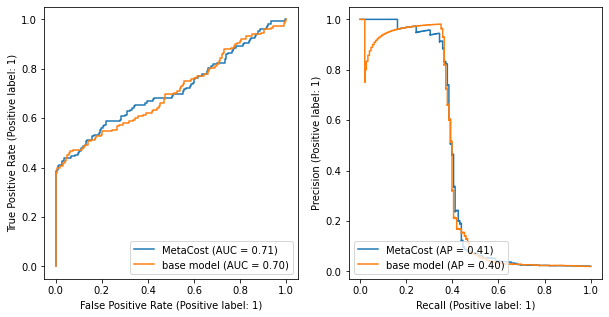

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

RocCurveDisplay.from_estimator(aux, X_test, y_test, ax=ax[0], name='MetaCost')
RocCurveDisplay.from_estimator(baseline, X_test, y_test, ax=ax[0], name='base model')

PrecisionRecallDisplay.from_estimator(aux, X_test, y_test, ax=ax[1], name='MetaCost')
PrecisionRecallDisplay.from_estimator(baseline, X_test, y_test, ax=ax[1], name='base model')

plt.show()

### Let us look at the costs!

Given the cost matrix $C_{lk} = \mathrm{cost}(\hat y = l| y = k)$ and the estimated probabilities $\mathbb P(Y = k|X=x)$, the estimated cost for instance $(x_i, y_i)$ is

$$\mathbb E[C|Y=y_i] = \sum_k \mathbb E[C|\hat Y_i = k, Y=y_i] \mathbb P(\hat Y_i = k)$$
$$\mathbb E[C|Y=y_i] = \sum_k  C_{k,y_i} \mathbb P(\hat Y_i = k)$$

To simplify, if we denote $C_i$ as the variable with expectation given by $\mathbb E[C_i] = \mathbb E[C|Y=y_i]$ as above, then we can define the **mean total cost** as

$$C := \frac 1N \sum_{i=1}^N C_i,$$

whose expected value is

$$\mathbb E[C] = \frac 1 N \sum_{i=1}^N \mathbb E[C|Y=y_i] = \frac{1}{N} \sum_{i=1}^N \sum_k  C_{k,y_i} \mathbb P(\hat Y_i = k)$$

and whose standard deviation is 

$$\begin{align*}
\sqrt{\mathrm{Var}\,C} &= \left[\frac{1}{N^2} \sum_{i=1}^N \mathrm{Var}\, C_i\right]^{1/2}\\
&= \frac{1}{N} \left[\sum_{i=1}^N \mathrm{Var}\, C_i\right]^{1/2}
\end{align*}$$

which can be calculated as follows:

In [32]:
def total_cost_and_std(y_true, y_probs, cost_dict, classes):
    n = len(y_true)
    df = pd.DataFrame({'y_true': y_true})
    for i, class_ in enumerate(classes):
        df[f'cost_{class_}'] = df['y_true'].\
            apply(lambda y: (class_, y)).\
            map(cost_dict)
        df[f'prob_{class_}'] = y_probs[:,i]

        df[f'expected_cost_{class_}'] = df[f'cost_{class_}'] * df[f'prob_{class_}']
        df[f'expected_cost_{class_}_squared'] = df[f'cost_{class_}']**2 * df[f'prob_{class_}']

    df['expected_cost'] = df[[f'expected_cost_{class_}' for class_ in classes]].sum(axis=1)
    df['expected_cost_squared'] = df[[f'expected_cost_{class_}_squared' for class_ in classes]].sum(axis=1)
    df['variance'] = df['expected_cost_squared'] - df['expected_cost']**2
    total_cost, var = df[['expected_cost', 'variance']].sum().values
    
    mean_cost = total_cost/n
    std = np.sqrt(var)/n
    
    return mean_cost, std

In [33]:
mean_cost, cost_std = total_cost_and_std(y_test, aux.predict_proba(X_test), cost, [0,1])
print(f"Mean cost MetaCost test: {round(mean_cost,3)} +/- {round(cost_std,3)}")

mean_cost, cost_std = total_cost_and_std(y_train, aux.predict_proba(X_train), cost, [0,1])
print(f"Mean cost MetaCost train: {round(mean_cost, 3)} +/- {round(cost_std, 3)}")

print("-"*30)
mean_cost, cost_std = total_cost_and_std(y_test, baseline.predict_proba(X_test), cost, [0,1])
print(f"Mean cost baseline test: {round(mean_cost, 3)} +/- {round(cost_std, 3)}")

mean_cost, cost_std = total_cost_and_std(y_train, baseline.predict_proba(X_train), cost, [0,1])
print(f"Mean cost baseline train: {round(mean_cost, 3)} +/- {round(cost_std, 3)}")

Mean cost MetaCost test: -0.04 +/- 0.041
Mean cost MetaCost train: -0.638 +/- 0.048
------------------------------
Mean cost baseline test: 0.018 +/- 0.044
Mean cost baseline train: -0.594 +/- 0.05


So our cost in the cost-sensitive model is significantly lower.

### Trying logistic regression

In [34]:
# first index is predicted class, second is real class
cost = {
    (1,0): 1.0,
    (0,1): 50.0,
    (1,1): -0.05,
    (0,0): 0.0
}

In [35]:
aux = MetaCost(LogisticRegression(penalty='l1', solver='saga'),
                total_bootstrap_samples=20,
                frac_samples=0.9,
                cost_matrix=cost,
                random_state=3,
                n_jobs=-1).\
    fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [36]:
print(np.bincount(aux.y_))
print(np.bincount(aux.y_new_))

[22055   445]
[15472  7028]


This HEAVILY balances the model, which might be dangerous

In [37]:
baseline = LogisticRegression(penalty='l1', solver='saga', max_iter=500).fit(X_train, y_train)

In [38]:
mean_cost, cost_std = total_cost_and_std(y_test, aux.predict_proba(X_test), cost, [0,1])
print(f"Mean cost MetaCost test: {round(mean_cost,3)} +/- {round(cost_std,3)}")

mean_cost, cost_std = total_cost_and_std(y_train, aux.predict_proba(X_train), cost, [0,1])
print(f"Mean cost MetaCost train: {round(mean_cost, 3)} +/- {round(cost_std, 3)}")

print("-"*30)
mean_cost, cost_std = total_cost_and_std(y_test, baseline.predict_proba(X_test), cost, [0,1])
print(f"Mean cost baseline test: {round(mean_cost, 3)} +/- {round(cost_std, 3)}")

mean_cost, cost_std = total_cost_and_std(y_train, baseline.predict_proba(X_train), cost, [0,1])
print(f"Mean cost baseline train: {round(mean_cost, 3)} +/- {round(cost_std, 3)}")

Mean cost MetaCost test: 0.689 +/- 0.005
Mean cost MetaCost train: 0.668 +/- 0.004
------------------------------
Mean cost baseline test: 0.934 +/- 0.02
Mean cost baseline train: 0.921 +/- 0.012


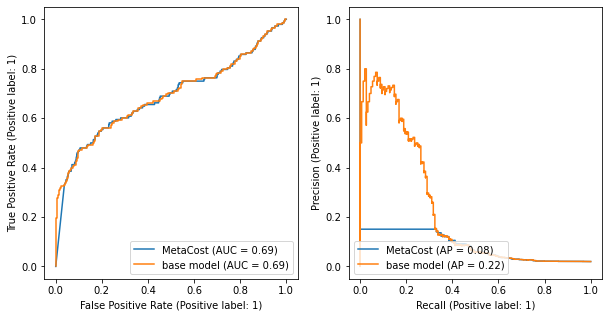

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

RocCurveDisplay.from_estimator(aux, X_test, y_test, ax=ax[0], name='MetaCost')
RocCurveDisplay.from_estimator(baseline, X_test, y_test, ax=ax[0], name='base model')

PrecisionRecallDisplay.from_estimator(aux, X_test, y_test, ax=ax[1], name='MetaCost')
PrecisionRecallDisplay.from_estimator(baseline, X_test, y_test, ax=ax[1], name='base model')

plt.show()